# Conditional Entropy estimate for continuous Y
In this notebook, we repeat our algorithm (see Honest Sampling notebook) on continuous Y data.

## Sampling Code

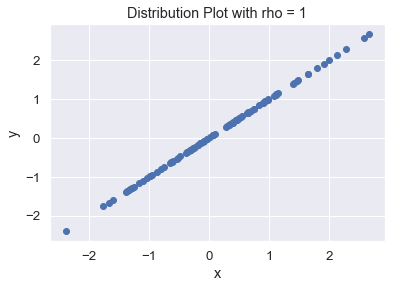

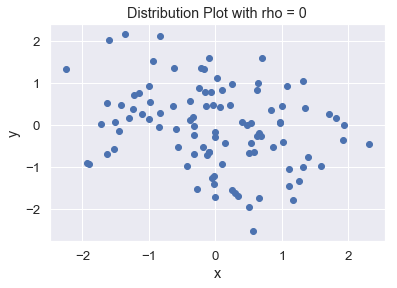

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
%matplotlib inline

def get_cont_sample(n,  rho):
    x_sample = []
    y_sample = []
    means = np.zeros(2)
    cov = np.array(((1, rho), (rho, 1)))
    for i in range(n):
        x = np.random.multivariate_normal(means, cov)
        x_sample.append(x[0])
        y_sample.append(x[1])
    return np.array(x_sample), np.array(y_sample)



X, y = get_cont_sample(100, 1)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

X, y = get_cont_sample(100, 0)
plt.scatter(X, y, c = 'b')
plt.title("Distribution Plot with rho = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Algorithm Development
Since our Y is continous not categorical, we can not use class probabilities as our posterior distribution. Instead, we will construct an empircal cdf from the elements in each leaf node as our conditional distribution of Y given X

In [2]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor



def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        inspect_leaf_elems(leaf_elems)
        break
    return
np.warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Uncorrelated Data

In [4]:
X, y = get_cont_sample(1000, 0)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

[1.4092930372599775, 0.6276251040639907, 1.1769886192910388]
[0.2657743518490584, 0.005670499847074233, -1.0028620149765068]
[-0.30598584226862446, 0.5209670627707994, -0.07426198074209005]
[-1.1498255492381144, -0.5743467197990109, 1.4192699884919597, 0.8513542559563927]
[-0.18930893852920644, 1.222973788978089, 2.767250407153513]


## Correlated Data

In [5]:
X, y = get_cont_sample(1000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

[-2.6640162855689775, -2.5437450827195494]
[-2.012155341210433, -1.9895633045281393, -1.9886843332915243, -2.008300583390162]
[-1.7670903093675046, -1.7697767646191862]
[-1.7020925188614304, -1.696681975539723]
[-1.5480791892117949, -1.523999569112268]


When our data is very correlated ($\rho$ = 1), we see that the elements in our leaf elements actually make sense and are close together. However, when our data is uncorrelated ($\rho$ = 0), we see that our elements are very widespread. This is exactly what we expect.

However, the count of the elements in our leaf nodes are all pretty similar. So, a naive binning strategy to create an empirical cdf will result in the same probability distribution (just 1/n for each sample point, where n is number of elements in leaf node). Thus, we need a way of incorporating the spread of our data.

We can do this by assigning a "uniform distribution" between every 2 adjacent order statistics. However, if the samples are close together, we get negaive entropy which doesn't make sense. So the overarching problem is given this blocky posterior distribution, how do I approximate the entropy?

https://en.wikipedia.org/wiki/Entropy_estimation

From the wikipedia article, since we do not know the true distribution, the way to go seems to be the histogram approimator! If we get negative entropy value, this means that our bins were too close together (very little entropoy!). Thus, I will just set that particular f(x)log(f(x)) to 0 whenever we run into this case. 


In [4]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].item()).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        # initialize at 0
        entropy = 0.
        n = len(elem)
        for i in range(1, n):
            incr = (-1/n)*np.log((1/n)/(elem[i] - elem[i - 1]))
            # if valid, add probability
            if incr > 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(1000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

0.018313483994129156

We now do some tests.
When the correlation is 0, our posterior distribution is just a normal with variance 1. We have calculated this before as .356.

When the correlation is 1, there is no entropy after you know X, so the conditional entropy is 0.

In [8]:
X, y = get_cont_sample(2000, 0)
X = np.array(X).reshape(-1, 1)
print("Estimated Value", rf_entropy_estimate_bagging(X, y, 200, .32))
print("True Value", 1.41)

Estimated Value 0.6414487574125532
True Value 1.41


In [9]:
X, y = get_cont_sample(5000, 1)
X = np.array(X).reshape(-1, 1)
print("Estimated Value", rf_entropy_estimate_bagging(X, y, 500, .32))
print("True Value", 0)

Estimated Value 0.003769416473261647
True Value 0


## Problem with Algorithm
Todo: create actual plots
In lieu of plots, I have just been running the algorithm a bunch of times. Here are the following good properties:
1. When X and Y are dependent, the conditional entropy is close to 0!
2. As we increase rho (make X and Y more dependent), the conditional entropy drops to 0!  

However, one major problem is that when I make the data completely independent (rho is 0), our conditional entropy value is no where close. I believe this is because it takes a lot of samples for it to converge correctly (the conditional entropy grows larger as you increase samples). Below I will investigate what exactly the conditional distirbution of Y given X looks like.

In [ ]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].item()).item()])
    # for every x, approximate histogram entropy
    
    test = posterior_counts[0]
    plt.hist(test, normed=True, bins=30)
    plt.show()
    
    """
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        # initialize at 0
        entropy = 0.
        n = len(elem)
        for i in range(1, n):
            incr = (-1/n)*np.log((1/n)/(elem[i] - elem[i - 1]))
            # if valid, add probability
            if incr > 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)"""
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(20000, 0)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

This is very cool! when our data is independent, our posterior distribution of Y given X is just the distribution of Y ( a normal with 0 mean).

In [ ]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].item()).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].item()).item()])
    # for every x, approximate histogram entropy
    
    test = posterior_counts[0]
    plt.hist(test, normed=True, bins=30)
    plt.show()
    
    """
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        # initialize at 0
        entropy = 0.
        n = len(elem)
        for i in range(1, n):
            incr = (-1/n)*np.log((1/n)/(elem[i] - elem[i - 1]))
            # if valid, add probability
            if incr > 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)"""
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(20000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 200, .32)

This is also good. We get a spike around certain values that are very close together when X and Y are dependent. That is, there is very little entropy.

The problem with our algorithm is that our histogram approximation loses a lot of entropy when the elements are close together.
We will try fixed sizes.

In [5]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        entropy = 0.
        hist = np.histogram(elem, bins = "auto")
        pdf = hist[0]/len(elem)
        for i in range(len(pdf)):
            incr = -pdf[i]*np.log(pdf[i]/(hist[1][i + 1] - hist[1][i]))
            if not np.isnan(incr) and incr >= 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(2000, 1)
X = np.array(X).reshape(-1, 1)
rf_entropy_estimate_bagging(X, y, 500, .32)

0.020286196904828777

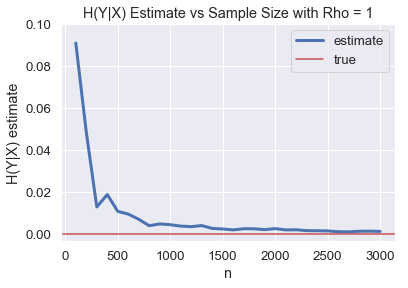

In [36]:
def get_cond_entropy_vs_n(rho):
    conditional_entropy = []
    sample_sizes = [i*100 for i in range(1, 31)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_cont_sample(elem, rho)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

#sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy, marker = "None",)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate", linewidth = 3)
line_true = plt.axhline(y=0, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymax = .1)
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Rho = 1")
plt.show()

## Multidimensonal Case

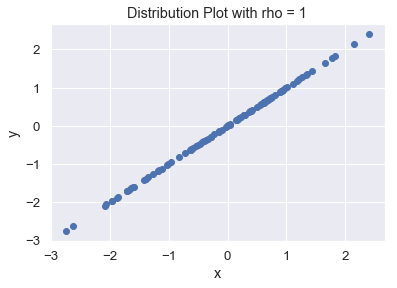

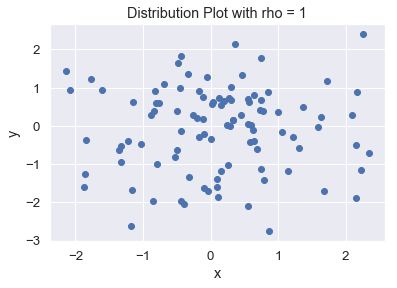

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
%matplotlib inline

def get_cont_sample_multi(n,  rho, d):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    cov = np.identity(d)
    cov[0, 1] = rho
    cov[1, 0] = rho
    for i in range(n):
        x = np.random.multivariate_normal(means, cov)
        y_sample.append(x[0])
        x_sample.append(x[1:])
    return np.array(x_sample), np.array(y_sample)


X, y = get_cont_sample_multi(100, 1, 5)
X_2 = [x[0] for x in X]
plt.scatter(X_2, y, c = 'b')
plt.title("Distribution Plot with rho = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
X_3 = [x[1] for x in X]
plt.scatter(X_3, y, c = 'b')
plt.title("Distribution Plot with rho = 1")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [4]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import math

def inspect_leaf_elems(leaf_elems):
    count = 0
    for leaf in leaf_elems:
        if len(leaf) > 1:
            print(leaf)
            count += 1
        if count == 5:
            return

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 5):
    model = BaggingRegressor(DecisionTreeRegressor(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.ceil(X.shape[1]/3))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    posterior_counts = [[] for _ in range(len(X))]
    for tree_idx in range(n_estimators):
        tree = model[tree_idx]
        unsampled_indices = np.where(model.estimators_samples_[tree_idx] == False)[0]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        node_counts = tree.tree_.n_node_samples
        leaf_elems = [[] for _ in range(len(node_counts))]
        for prob_index in prob_indices:
            leaf_elems[tree.apply(X[prob_index].reshape(1, -1)).item()].append(y[prob_index])
        for eval_index in eval_indices:
            # for every x, collect all y samples in the leaf nodes x fell into (for entire forest)
            posterior_counts[eval_index].extend(leaf_elems[tree.apply(X[eval_index].reshape(1, -1)).item()])
    # for every x, approximate histogram entropy
    entropy_estimates = []
    for elem in posterior_counts:
        elem.sort()
        entropy = 0.
        hist = np.histogram(elem, bins = "auto")
        pdf = hist[0]/len(elem)
        for i in range(len(pdf)):
            incr = -pdf[i]*np.log(pdf[i]/(hist[1][i + 1] - hist[1][i]))
            if not np.isnan(incr) and incr >= 0:
                entropy += incr
        entropy_estimates.append(entropy)
    return np.mean(entropy_estimates)
np.warnings.filterwarnings('ignore')

X, y = get_cont_sample(500, 1)
rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 500, .32)



0.09401879455171078

In [9]:
X, y = get_cont_sample(5000, 1, 4)
rf_entropy_estimate_bagging(X, y, 500, .32)

[[1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


0.0016494742259919506

[0.03403421316900803, 0.01669774951903922, 0.007428723932783427, 0.004792162709913499, 0.00448526140804572, 0.003238970018269909, 0.0021417045604021742, 0.0024833895491357064, 0.0017059361820577791, 0.0016176961376958854, 0.0015496954105250448, 0.0011291048904697582, 0.0012318271985536909, 0.001151787160620944, 0.0013441029010683569, 0.0008552522430173271, 0.0008375444179101459, 0.0007755605063637254, 0.0007912917842041256, 0.0008611282134989849, 0.0007188767640261513, 0.0006738749695725652, 0.0005975172273460223, 0.0005623497786595438, 0.0005336325068420895]


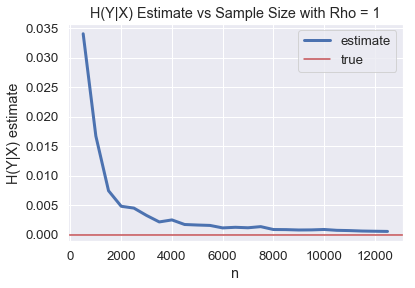

In [60]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(rho, d):
    conditional_entropy = []
    sample_sizes = [i*500 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_cont_sample(elem, rho, d)
        conditional_entropy.append(rf_entropy_estimate_bagging(X, y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 4)
print(cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate", linewidth = 3)
line_true = plt.axhline(y=0, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Rho = 1")
plt.show()

In [7]:
from scipy.stats import multivariate_normal


def estimate_multivariate_entropy(X):
    mean = np.mean(X, axis = 0)
    covar = np.cov(X, rowvar = False)
    return multivariate_normal.entropy(mean, covar)

def plugin_estimate_continuous(X, y):
    joint = np.concatenate((y.reshape(-1, 1), X), axis = 1)
    joint_entropy = estimate_multivariate_entropy(joint)
    h_x = estimate_multivariate_entropy(X)
    cond_entr =  joint_entropy - h_x
    if cond_entr < 0:
        return 0
    return cond_entr

def truth_1d(rho):
    return multivariate_normal.entropy([0, 0], np.array([[1, rho], [rho, 1]])) - multivariate_normal.entropy([0], [1]) 

X, y = get_cont_sample_multi(5000, 0, 10)
print(plugin_estimate_continuous(X, y))
print(truth_1d(0))

1.405043734932601
1.4189385332046727


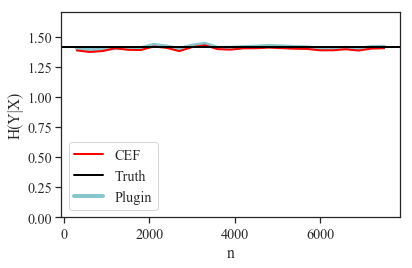

In [32]:
def get_cond_entropy_vs_n(rho, d):
    conditional_entropy = []
    plugin_estimate = []
    sample_sizes = [i*300 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_cont_sample_multi(elem, rho, d)
        conditional_entropy.append(rf_entropy_estimate_bagging(X, y, 300, .32, depth = 30))
        plugin_estimate.append(plugin_estimate_continuous(X, y))
    return sample_sizes, conditional_entropy, plugin_estimate

sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n(0, 40)
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "Plugin", linewidth = 4, color = "#87C6CC")
line_est, = plt.plot(sample_sizes, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_true = plt.axhline(y=1.41, color='#020202', linestyle='-', linewidth = 2, label = "Truth")
plt.xlabel("n")
plt.ylabel("H(Y|X)")
plt.legend(handles=[line_est, line_true, line_plugin])
plt.ylim(ymax = 1.7)
plt.ylim(ymin = 0)
plt.tight_layout()
plt.savefig("cont_40d_rho0_lessn.png")
plt.show()

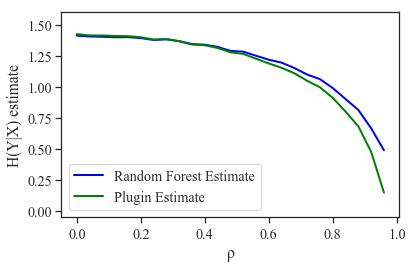

In [7]:


def get_cond_entropy_vs_mu(n, d):
    conditional_entropy = []
    plugin_estimate = []
    rho = [i*.04 for i in range(0, 25)]
    for elem in tqdm_notebook(rho):
        X, y = get_cont_sample_multi(n, elem, d)
        plugin_estimate.append(plugin_estimate_continuous(X, y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X, y, 300, .32, depth = 30))
    return rho, conditional_entropy, plugin_estimate

rhos, cond_entropy, plugin_estimate = get_cond_entropy_vs_mu(20000, 40)

sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(rhos, cond_entropy, label = "Random Forest Estimate", linewidth = 2, color = "blue")
line_plugin, = plt.plot(rhos, plugin_estimate, label = "Plugin Estimate", linewidth = 2, color = "green")
plt.ylim(ymin = -.05)
plt.ylim(ymax = 1.6)
plt.legend(handles=[line_est, line_plugin])
plt.xlabel(u"\u03C1")
plt.ylabel("H(Y|X) estimate")
plt.tight_layout()
plt.savefig("cont_40d_n20000_conv0.png")
plt.show()

In [31]:
from tqdm import tqdm_notebook

def get_cond_entropy_vs_n(rho):
    conditional_entropy = []
    plugin_estimate = []
    sample_sizes = [i*400 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_cont_sample(elem, rho)
        plugin_estimate.append(plugin_estimate_continuous(X.reshape(-1, 1), y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X.reshape(-1, 1), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy, plugin_estimate

sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n(0)
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "Plugin", linewidth = 2, color = "#94D6C9")
line_est, = plt.plot(sample_sizes, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_true = plt.axhline(y=1.41, color='#4a484c', linestyle='-', label = "Truth")
plt.xlabel("n")
plt.ylabel("H(Y|X)")
plt.legend(handles=[line_est, line_true, line_plugin])
plt.ylim(ymax = 1.6)
plt.ylim(ymin = 0)
plt.tight_layout()
plt.savefig("cont_1d_rho0_more_n.png")
plt.show()

KeyboardInterrupt: 

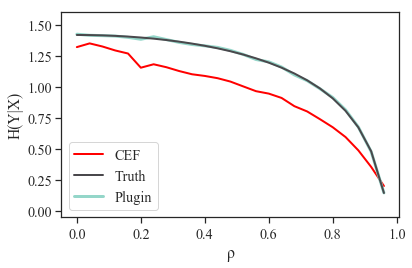

In [30]:
from tqdm import tqdm_notebook


def get_cond_entropy_vs_mu(n):
    conditional_entropy = []
    plugin_estimate = []
    truth = []
    rho = [i*.04 for i in range(0, 25)]
    for elem in tqdm_notebook(rho):
        X, y = get_cont_sample(n, elem)
        plugin_estimate.append(plugin_estimate_continuous(X.reshape(-1, 1), y))
        conditional_entropy.append(rf_entropy_estimate_bagging(X.reshape(-1, 1), y, 300, .32, depth = 30))
        truth.append(truth_1d(elem))
    return rho, conditional_entropy, plugin_estimate, truth

#rhos, cond_entropy, plugin_estimate, truth = get_cond_entropy_vs_mu(10000)

sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(rhos, cond_entropy, label = "CEF", linewidth = 2, color = "red")
line_plugin, = plt.plot(rhos, plugin_estimate, label = "Plugin", linewidth = 3, color = "#94D6C9")
line_truth, = plt.plot(rhos, truth, label = "Truth", linewidth = 2, color = "#4a484c")

plt.ylim(ymin = -.05)
plt.ylim(ymax = 1.6)
plt.legend(handles=[line_est, line_truth, line_plugin])
plt.xlabel(u"\u03C1")
plt.ylabel("H(Y|X)")
plt.tight_layout()
plt.savefig("cont_1d_n10000_conv0.png")
plt.show()